# Workflow DeepLabCut - Alternate Data

## Introduction


This notebook provides a general introduction to DataJoint use via Element DeepLabcut. It follows the same structure as other notebooks in this directory, but uses data from the DeepLabCut team. 

We recommend the other notebooks as they provide access to a pretrained model and allow for a more in-depth exploration of the features of the Element.

## Example data


### Download

If you've already cloned the [main DLC repository](https://github.com/DeepLabCut/DeepLabCut), you already have this folder under `examples/openfield-Pranav-2018-10-30`. [This link](https://downgit.github.io/#/home?url=https://github.com/DeepLabCut/DeepLabCut/tree/master/examples/openfield-Pranav-2018-10-30) via [DownGit](https://downgit.github.io/) will start the single-directory download automatically as a zip. Unpack this zip and place it in a directory we'll refer to as your root.

### Structure

The directory will be organized as follows within your chosen root
directory.

```
 /your-root/openfield-Pranav-2018-10-30/
   - config.yaml
   - labeled-data
      - m4s1
          - CollectedData_Pranav.csv
          - CollectedData_Pranav.h5
          - img0000.png
          - img0001.png
          - img0002.png
          - img{...}.png
          - img0114.png
          - img0115.png
   - videos
       - m3v1mp4.mp4
```

For those unfamiliar with DLC...
- `config.yaml` contains all the key parameters of the project, including
   - file locations (currently empty)
   - body parts
   - cropping information
- `labeled-data` includes the frames coordinates for each body part in the training video
- `videos` includes the full training video for this example

Part of the demo setup involves an additional
command (as [shown here](https://github.com/DeepLabCut/DeepLabCut/blob/master/examples/JUPYTER/Demo_labeledexample_Openfield.ipynb)) to revise the project path within config file as well as generate the `training-datasets` directory.

In [ ]:
your_root='/fill/in/your/root/with\ escaped\ spaces'
from deeplabcut.create_project.demo_data import load_demo_data
load_demo_data(your_root+'/openfield-Pranav-2018-10-30/config.yaml')

### New video

Later, we'll use the first few seconds of the training video as a 'separate session' to demonstrate pose estimation within the Element. `ffmpeg` is a dependency of DeepLabCut
that can splice the training video for a demonstration purposes. The command below saves
the first 2 seconds of the training video as a copy.

- `-n` do not overwrite
- `-hide_banner -loglevel error` less verbose output
- `-ss 0 -t 2` start at second 0, add 2 seconds
- `-i {vid_path}` input this video
- `-{v/a}codec copy` copy the video and audio codecs of the input
- `{vid_path}-copy.mp4` output file

In [ ]:
vid_path = your_root + '/openfield-Pranav-2018-10-30/videos/m3v1mp4'
cmd = (f'ffmpeg -n -hide_banner -loglevel error -ss 0 -t 2 -i {vid_path}.mp4 '
       + f'-vcodec copy -acodec copy {vid_path}-copy.mp4')
import os; os.system(cmd)

0

## Configuring DataJoint

### DataJoint Local Config

- To run `workflow-deeplabcut`, we need to set up the DataJoint configuration file, called `dj_local_conf.json`, unique to each machine.

- The config only needs to be set up once, skip to the next section.

- By convention, we set a local config in the workflow directory. You may be interested in [setting a global config](https://docs.datajoint.org/python/setup/01-Install-and-Connect.html).

In [ ]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='workflow-deeplabcut', ("Please move to the "
                                                              + "workflow directory")

### Configure database credentials

Now let's set up the host, user and password in the `dj.config` following [instructions here](https://tutorials.datajoint.io/setting-up/get-database.html).

In [ ]:
import datajoint as dj
import getpass
dj.config['database.host'] = '{YOUR_HOST}'
dj.config['database.user'] = '{YOUR_USERNAME}'
dj.config['database.password'] = getpass.getpass() # enter the password securely

 ····


You should be able to connect to the database at this stage.

In [ ]:
dj.conn()

### Workflow-specific items

**Prefix:** Giving a prefix to your schema could help manage privelages on a server. 
- If we set prefix `neuro_`, every schema created with the current workflow will start with `neuro_`, e.g. `neuro_lab`, `neuro_subject`, `neuro_imaging` etc.
- Teams who work on the same schemas should use the same prefix, set as follows:

In [ ]:
dj.config['custom'] = {'database.prefix': 'neuro_'}

**Root dir:** `custom` keeps track of your root directory for this project. With multiple roots the Element will figure out which to use based on the files it expects. 

- Please set one root to the parent directory of DLC's `openfield-Pranav-2018-10-30` example.
- In other cases, this should be the parent of your DLC project path.

We can then check that the path connects with a tool from [element-interface](https://github.com/datajoint/element-interface).

In [ ]:
dj.config['custom'] = {'dlc_root_data_dir' : ['your-root1', 'your-root2']}

from element_interface.utils import find_full_path
data_dir = find_full_path(dj.config['custom']['dlc_root_data_dir'],
                          'openfield-Pranav-2018-10-30')
assert data_dir.exists(), "Please check the that you have the folder openfield-Pranav"

### Saving the config


With the proper configurations, we could save this as a file, either as a local json file, or a global file. DataJoint will default to a local file, then check for a global if none is found.

In [ ]:
dj.config.save_local() # saved as dj_local_conf.json in the root workflow dir
# dj.config.save_global() # saved as .datajoint_config.json in your home dir

## Workflow Structure

### Schemas, Diagrams and Tables

Schemas are conceptually related sets of tables. By importing schemas from `workflow_deeplabcut.pipeline`, we'll declare the tables on the server with the prefix we set. If these tables are already declared, we'll gain access. For more information about lab, animal and session Elements, see [session workflow](https://github.com/datajoint/workflow-session).

- `dj.list_schemas()` lists all schemas a user has access to in the current database
- `<schema>.schema.list_tables()` will provide names for each table in the format used under the hood.

In [1]:
import datajoint as dj
from workflow_deeplabcut.pipeline import lab, subject, session, train, model

dj.list_schemas()

train.schema.list_tables()

Connecting cbroz@dss-db.datajoint.io:3306


['#training_param_set',
 'video_set',
 'video_set__file',
 'training_task',
 '__model_training']

`dj.Diagram()` plots tables and dependencies in a schema. To see additional upstream or downstream connections, add `- N` or `+ N`.

- `train`: Optional schema to manage model training within DataJoint
- `model`: Schema to manage pose estimation

#### Table Types

- **Manual table**: green box, manually inserted table, expect new entries daily, e.g. Subject, ProbeInsertion.  
- **Lookup table**: gray box, pre inserted table, commonly used for general facts or parameters. e.g. Strain, ClusteringMethod, ClusteringParamSet.  
- **Imported table**: blue oval, auto-processing table, the processing depends on the importing of external files. e.g. process of Clustering requires output files from kilosort2.  
- **Computed table**: red circle, auto-processing table, the processing does not depend on files external to the database, commonly used for     
- **Part table**: plain text, as an appendix to the master table, all the part entries of a given master entry represent a intact set of the master entry. e.g. Unit of a CuratedClustering.

#### Table Links

- **One-to-one primary**: thick solid line, share the exact same primary key, meaning the child table inherits all the primary key fields from the parent table as its own primary key.     
- **One-to-many primary**: thin solid line, inherit the primary key from the parent table, but have additional field(s) as part of the primary key as well
- **Secondary dependency**: dashed line, the child table inherits the primary key fields from parent table as its own secondary attribute.

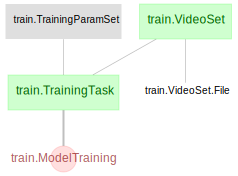

In [3]:
dj.Diagram(train) #- 1

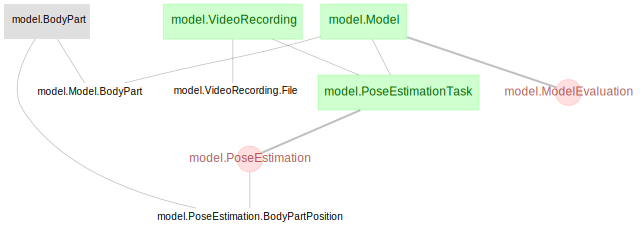

In [3]:
dj.Diagram(model)

### Common Table Functions


- `<table>()` show table contents
- `heading` shows attribute definitions
- `describe()` show table defintiion with foreign key references

In [3]:
model.VideoRecording.File()

subject,session_datetime,recording_id,file_id,"file_path filepath of video, relative to root data directory"


In [8]:
model.Model.heading

# 
model_name           : varchar(64)                  # user-friendly model name
---
task                 : varchar(32)                  # task in the config yaml
date                 : varchar(16)                  # date in the config yaml
iteration            : int                          # iteration/version of this model
snapshotindex        : int                          # which snapshot for prediction (if -1, latest)
shuffle              : int                          # which shuffle of the training dataset
trainingsetindex     : int                          # which training set fraction to generate model
scorer               : varchar(64)                  # scorer/network name - DLC's GetScorerName()
config_template      : longblob                     # dictionary of the config for analyze_videos()
project_path         : varchar(255)                 # DLC's project_path in config relative to root
model_prefix=""      : varchar(32)                  # 
model_description="" : varc

In [7]:
train.TrainingTask.describe()

# Specification for a DLC model training instance
-> train.VideoSet
-> train.TrainingParamSet
training_id          : int                          
---
model_prefix=""      : varchar(32)                  
project_path=""      : varchar(255)                 # DLC's project_path in config relative to root



'# Specification for a DLC model training instance\n-> train.VideoSet\n-> train.TrainingParamSet\ntraining_id          : int                          \n---\nmodel_prefix=""      : varchar(32)                  \nproject_path=""      : varchar(255)                 # DLC\'s project_path in config relative to root\n'

## Running the Workflow

`Pipeline.py` activates the DataJoint `elements` and declares other required tables.

In [2]:
import datajoint as dj
from workflow_deeplabcut.pipeline import lab, subject, session, train, model

# Directing our pipeline to the appropriate config location
from element_interface.utils import find_full_path
from workflow_deeplabcut.paths import get_dlc_root_data_dir
config_path = find_full_path(get_dlc_root_data_dir(), 
                             'openfield-Pranav-2018-10-30/config.yaml')

Connecting cbroz@dss-db.datajoint.io:3306


### Manually Inserting Entries

#### Upstream tables

We can insert entries into `dj.Manual` tables (green in diagrams) by directly providing values as a dictionary. 

In [7]:
session.Session.heading

# 
subject              : varchar(32)                  # 
session_datetime     : datetime(3)                  # 

In [4]:
subject.Subject.insert1(dict(subject='subject6', 
                             sex='F', 
                             subject_birth_date='2020-01-01', 
                             subject_description='hneih_E105'))
session_keys = [dict(subject='subject6', session_datetime='2021-06-02 14:04:22'),
                dict(subject='subject6', session_datetime='2021-06-03 14:43:10')]
session.Session.insert(session_keys)

We can look at the contents of this table and restrict by a value.

In [6]:
session.Session() & "session_datetime > '2021-06-01 12:00:00'" & "subject='subject6'"

subject,session_datetime
subject6,2021-06-02 14:04:22
subject6,2021-06-03 14:43:10


#### DeepLabcut Tables

The `VideoSet` table in the `train` schema retains records of files generated in the video labeling process (e.g., `h5`, `csv`, `png`). DeepLabCut will refer to the `mat` file located under the `training-datasets` directory.

In [ ]:
train.VideoSet.insert1({'video_set_id': 1})
labeled_dir = 'openfield-Pranav-2018-10-30/labeled-data/m4s1/'
training_files = ['CollectedData_Pranav.h5',
                  'CollectedData_Pranav.csv',
                  'img0000.png']
for idx, filename in training_files:
    train.VideoSet.File.insert1({'video_set_id': 1,
                                 'file_id': idx,   
                                 'file_path': (labeled_dir + file)})
train.VideoSet.File.insert1({'video_set_id':1, 'file_id': 4, 'file_path': 
                            'openfield-Pranav-2018-10-30/videos/m3v1mp4.mp4'})

In [6]:
train.VideoSet.File()

video_set_id,file_path
1,openfield-Pranav-2018-10-30/labeled-data/m4s1/CollectedData_Pranav.csv
1,openfield-Pranav-2018-10-30/labeled-data/m4s1/CollectedData_Pranav.h5
1,openfield-Pranav-2018-10-30/labeled-data/m4s1/img0000.png
1,openfield-Pranav-2018-10-30/videos/m3v1mp4.mp4


### Training a Network

First, we'll add a `ModelTrainingParamSet`. This is a lookup table that we can reference when training a model.

In [10]:
train.TrainingParamSet.heading

paramset_idx         : smallint                     # 
---
paramset_desc        : varchar(128)                 # 
param_set_hash       : uuid                         # hash identifying this parameterset
params               : longblob                     # dictionary of all applicable parameters

The `params` longblob should be a dictionary that captures all items for DeepLabCut's `train_network` function. At minimum, this is the contents of the project's config file, as well as `suffle` and `trainingsetindex`, which are not included in the config. 

In [ ]:
from deeplabcut import train_network
help(train_network) # for more information on optional parameters

Here, we give these items, load the config contents, and overwrite some defaults, including `maxiters`, to restrict our training iterations to 5.

In [7]:
import yaml

paramset_idx = 1; paramset_desc='OpenField'

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

Now, we add a `TrainingTask`. As a computed table, `ModelTraining` will reference this to start training when calling `populate()`

In [19]:
train.TrainingTask.heading

video_set_id         : int                          # 
paramset_idx         : smallint                     # 
training_id          : int                          # 
---
model_prefix=""      : varchar(32)                  # 
project_path=""      : varchar(255)                 # DLC's project_path in config relative to root

In [13]:
key={'video_set_id': 1, 'paramset_idx':1,'training_id':1,
     'project_path':'openfield-Pranav-2018-10-30/'}
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

video_set_id,paramset_idx,training_id,model_prefix,project_path DLC's project_path in config relative to root
1,1,1,,openfield-Pranav-2018-10-30/


In [8]:
train.ModelTraining.populate()

In [8]:
train.ModelTraining()

video_set_id,paramset_idx,training_id,"latest_snapshot latest exact snapshot index (i.e., never -1)",config_template stored full config file
1,1,1,5,=BLOB=


To resume training from a checkpoint, we would need to 
[edit the relevant config file](https://github.com/DeepLabCut/DeepLabCut/issues/70).
Emperical work from the Mathis team suggests 200k iterations for any true use-case.

### Tracking Joints/Body Parts

The `model` schema uses a lookup table for managing Body Parts tracked across models.

In [24]:
model.BodyPart.heading

# 
body_part            : varchar(32)                  # 
---
body_part_description="" : varchar(1000)                # 

Helper functions allow us to first, identify all the new body parts from a given config, and, second, insert them with user-friendly descriptions.

In [16]:
model.BodyPart.extract_new_body_parts(config_path)

Existing body parts: ['leftear' 'rightear' 'snout' 'tailbase']
New body parts: []


array([], dtype='<U8')

In [9]:
bp_desc=['Left Ear', 'Right Ear', 'Snout Position', 'Base of Tail']
model.BodyPart.insert_from_config(config_path,bp_desc)

Existing body parts: []
New body parts: ['leftear' 'rightear' 'snout' 'tailbase']
New descriptions: ['Left Ear', 'Right Ear', 'Snout Position', 'Base of Tail']


Insert 4 new body part(s)? [yes, no]:  yes


### Declaring/Evaluating a Model

We can insert into `Model` table for automatic evaluation

In [ ]:
model.Model.insert_new_model(model_name='OpenField-5',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='Open field model trained 5 iterations',
                             paramset_idx=1)

In [11]:
model.Model()

model_name user-friendly model name,task task in the config yaml,date date in the config yaml,iteration iteration/version of this model,"snapshotindex which snapshot for prediction (if -1, latest)",shuffle which shuffle of the training dataset,trainingsetindex which training set fraction to generate model,scorer scorer/network name - DLC's GetScorerName(),config_template dictionary of the config for analyze_videos(),project_path DLC's project_path in config relative to root,model_prefix,model_description,paramset_idx
OpenField-5,openfield,Oct30,0,-1,1,0,DLCresnet50openfieldOct30shuffle1,=BLOB=,openfield-Pranav-2018-10-30,,Open field model trained 5 iterations,1


`ModelEvaluation` will reference the `Model` using the `populate` method and insert the  output from DeepLabCut's `evaluate_network` function

In [47]:
model.ModelEvaluation.heading

model_name           : varchar(64)                  # user-friendly model name
---
train_iterations     : int                          # Training iterations
train_error=null     : float                        # Train error (px)
test_error=null      : float                        # Test error (px)
p_cutoff=null        : float                        # p-cutoff used
train_error_p=null   : float                        # Train error with p-cutoff
test_error_p=null    : float                        # Test error with p-cutoff

In [13]:
model.ModelEvaluation.populate()

Running  DLC_resnet50_openfieldOct30shuffle1_5  with # of training iterations: 5


/Users/cb/miniconda3/envs/venv-dlc/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Running evaluation ...


116it [01:17,  1.50it/s]


Analysis is done and the results are stored (see evaluation-results) for snapshot:  snapshot-5
Results for 5  training iterations: 95 1 train error: 245.06 pixels. Test error: 247.52  pixels.
With pcutoff of 0.4  train error: 239.24 pixels. Test error: 238.07 pixels
Thereby, the errors are given by the average distances between the labels by DLC and the scorer.
The network is evaluated and the results are stored in the subdirectory 'evaluation_results'.
Please check the results, then choose the best model (snapshot) for prediction. You can update the config.yaml file with the appropriate index for the 'snapshotindex'.
Use the function 'analyze_video' to make predictions on new videos.
Otherwise, consider adding more labeled-data and retraining the network (see DeepLabCut workflow Fig 2, Nath 2019)


In [14]:
model.ModelEvaluation()

model_name user-friendly model name,train_iterations Training iterations,train_error Train error (px),test_error Test error (px),p_cutoff p-cutoff used,train_error_p Train error with p-cutoff,test_error_p Test error with p-cutoff
OpenField-5,5,245.06,247.52,0.4,239.24,238.07


### Pose Estimation

To use our model, we'll first need to insert a session recoring into `VideoRecording`

In [ ]:
key = {'subject': 'subject6',
       'session_datetime': '2021-06-02 14:04:22',
       'recording_id': '1', 'device': 'Camera1'}
model.VideoRecording.insert1(key)

_ = key.pop('device') # get rid of secondary key from master table
key.update({'file_id': 1, 
            'file_path': 'openfield-Pranav-2018-10-30/videos/m3v1mp4-copy.mp4'})
model.VideoRecording.File.insert1(key)

In [13]:
model.VideoRecording.File()

subject,session_datetime,recording_id,file_id,"file_path filepath of video, relative to root data directory"
subject6,2021-06-02 14:04:22,1,1,openfield-Pranav-2018-10-30/videos/m3v1mp4-copy.mp4


`RecordingInfo` automatically populates with file information

In [14]:
model.RecordingInfo.populate()
model.RecordingInfo()

subject,session_datetime,recording_id,px_height height in pixels,px_width width in pixels,nframes number of frames,fps (Hz) frames per second,recording_datetime Datetime for the start of the recording,recording_duration video duration in seconds
subject6,2021-06-02 14:04:22,1,480,640,63,30,None,2.1


Next, we specify if the `PoseEstimation` table should load results from an existing file or trigger the estimation command. Here, we can also specify parameters for DeepLabCut's `analyze_videos` as a dictionary.

In [4]:
key = (model.VideoRecording & {'recording_id': '1'}).fetch1('KEY')
key.update({'model_name': 'OpenField-5', 'task_mode': 'trigger'})
key

{'subject': 'subject6',
 'session_datetime': datetime.datetime(2021, 6, 2, 14, 4, 22),
 'camera_id': 1,
 'recording_id': 1,
 'model_name': 'OpenField-5',
 'task_mode': 'trigger'}

In [5]:
model.PoseEstimationTask.insert_estimation_task(key,params={'save_as_csv':True})
model.PoseEstimation.populate()

By default, DataJoint will store results in a subdirectory
>       <processed_dir> / videos / device_<name>_recording_<#>_model_<name>
where `processed_dir` is optionally specified in the datajoint config. If unspecified, this will be the project directory. The device and model names are specified elsewhere in the schema.

We can get this estimation directly as a pandas dataframe.

In [9]:
model.PoseEstimation.get_trajectory(key)

scorer    OpenField-5                                                          \
bodyparts     leftear                               rightear                    
coords              x          y    z likelihood           x           y    z   
0            0.790677   7.965729  0.0   0.397091  115.835762  164.004028  0.0   
1            2.807120  10.973466  0.0   0.435590   10.124892  470.653931  0.0   
2            9.415764  16.290619  0.0   0.400282   10.313096  470.749420  0.0   
3            8.467562  15.072682  0.0   0.407272   10.299086  470.716309  0.0   
4            1.952696  10.845516  0.0   0.388948   10.309416  470.719910  0.0   
..                ...        ...  ...        ...         ...         ...  ...   
58           5.497818  12.181496  0.0   0.503961   10.725180  470.430847  0.0   
59           4.192788  10.005349  0.0   0.455334   10.476208  470.846588  0.0   
60           2.216149  10.115728  0.0   0.420141   10.644203  471.036102  0.0   
61           5.196610  10.838953  0.0   0.484508  178.007233   72.935913  0.0   
62           2.678554  10.277241  0.0   0.426758   10.260103  471.321564  0.0   

scorer                                                                 \
bodyparts                 snout                              tailbase   
coords    likelihood          x           y    z likelihood         x   
0           0.518405  58.818291    4.837649  0.0   0.514612  4.134376   
1           0.514644  15.192053  472.954376  0.0   0.509128  4.339864   
2           0.513927  15.203813  473.046204  0.0   0.509683  4.241215   
3           0.515085  14.914599  472.946564  0.0   0.507931  4.296385   
4           0.511848  14.834159  472.920166  0.0   0.504538  4.267960   
..               ...        ...         ...  ...        ...       ...   
58          0.505526  15.931270  474.692963  0.0   0.507564  9.060750   
59          0.499014   3.508626   26.821339  0.0   0.537064  3.786860   
60          0.487316   3.166887   26.835373  0.0   0.548109  8.188313   
61          0.576688   4.478888   26.513628  0.0   0.531905  4.350879   
62          0.502590  15.026831  472.492065  0.0   0.528700  8.123420   

scorer                                 
bodyparts                              
coords              y    z likelihood  
0          463.009460  0.0   0.717231  
1          462.988220  0.0   0.711722  
2          463.060944  0.0   0.709923  
3          463.385590  0.0   0.704007  
4          463.363556  0.0   0.702786  
..                ...  ...        ...  
58         481.278442  0.0   0.704268  
59         462.760376  0.0   0.689251  
60         481.524902  0.0   0.707340  
61         462.553345  0.0   0.703052  
62         481.642578  0.0   0.707681  

[63 rows x 16 columns]

<!-- Next Steps -->
.

## Workflow Automation

Below is a more automatic approach to run through the pipeline using some utility functions in the workflow using the `process.py` script to automatically trigger all computed tables.

Because we just inserted all the data, we'll delete using the command below to start over.

In [ ]:
from workflow_deeplabcut.process import run
safemode=None # Set to false to turn off confirmation prompts
(session.Session & 'subject="subject6"').delete(safemode=safemode)
train.TrainingParamSet.delete(safemode=safemode)
train.VideoSet.delete(safemode=safemode)

#### Automated Ingestion

Refer to the `user_data` folder in the workflow for CSVs to fill in various tables.

1. Upstream tables:
   - `subject.Subject` via `subjects.csv` 
   - `session.Session` via `sessions.csv`
2. `train` schema:
   - `train.TrainingParamSet` via `config_params.csv`
   - `train.VideoSet` via `train_videosets.csv`
3. `model` schema:
   - `model.VideoRecording` via `model_videos.csv`
   - `model.Model` via `model_model.csv`
  
Run automatic ingestion via functions in `workflow_deeplabcut.ingest` 

In [2]:
from workflow_deeplabcut.ingest import ingest_subjects, ingest_sessions, ingest_dlc_items
ingest_subjects(); ingest_sessions(); ingest_dlc_items()


---- Inserting 0 entry(s) into subject ----

---- Inserting 2 entry(s) into session ----

---- Inserting 2 entry(s) into session_directory ----

---- Inserting 2 entry(s) into session_note ----

---- Inserting 3 entry(s) into #model_training_param_set ----

---- Inserting 2 entry(s) into video_set ----

---- Inserting 8 entry(s) into video_set__file ----

---- Inserting 2 entry(s) into video_recording ----

---- Inserting 2 entry(s) into video_recording__file ----


#### Setting project variables

Set your root directory in your DataJoint config file, under `custom` as `dlc_root_data_dir`. 

In [4]:
import datajoint as dj; dj.config.load('dj_local_conf.json')
from element_interface.utils import find_full_path
data_dir = find_full_path(dj.config['custom']['dlc_root_data_dir'], # root from config
                          'openfield-Pranav-2018-10-30')            # DLC project dir
config_path = (data_dir / 'config.yaml')

#### Launching trainig

Pair training files with training parameters, and launch training via `process`. 

Note: DLC's model processes (e.g., Training, Evaluation) log a lot of information to the console, to quiet this, pass `verbose=False` to `process`

In [ ]:
key={'paramset_idx':1,'training_id':1,'video_set_id':1, 
     'project_path':'openfield-Pranav-2018-10-30/'}
train.TrainingTask.insert1(key, skip_duplicates=True)
run(verbose=True)
model.RecordingInfo()

Now, add to `Model`, including
- Include a user-friendly `model_name`
- Include the relative path for the project's `config.yaml`
- Add `shuffle` and `trainingsetindex`
- `insert_new_model` will prompt before inserting, but this can be skipped with `prompt=False`

In [ ]:
model.Model.insert_new_model(model_name='OpenField-5', 
                             dlc_config=config_path,
                             shuffle=1,
                             trainingsetindex=0,
                             paramset_idx=1, 
                             prompt=True, # True is the default behavior
                             model_description='Open field model trained 5 iterations')
run()

Add a pose estimation task, using
- All primary key information for a given recording
- Add the model and `task_mode` (i.e., load vs. trigger) to be applied
- Add any additional analysis parameters for `deeplabcut.analyze_videos`

In [ ]:
key=(model.VideoRecording & 'recording_id=2').fetch1('KEY')
key.update({'model_name': 'OpenField-5', 'task_mode': 'trigger'})
analyze_params={'save_as_csv':True} # add any others from deeplabcut.analyze_videos
model.PoseEstimationTask.insert_estimation_task(key,params=analyze_params)
run()

Retrieve estimated position data:

In [7]:
model.PoseEstimation.get_trajectory(key)

scorer    OpenField-5                                                       \
bodyparts     leftear                            rightear                    
coords              x         y    z likelihood         x           y    z   
0          125.213768  0.464425  0.0   0.142836  1.902155  184.619431  0.0   
1          125.009758  1.058969  0.0   0.136179  1.532405  183.668121  0.0   
2          123.785698  1.801253  0.0   0.150994  1.467412  183.721542  0.0   
3          122.621880  2.729937  0.0   0.150831  1.424251  184.009323  0.0   
4          123.729645  2.901060  0.0   0.163442  1.417472  183.914078  0.0   
..                ...       ...  ...        ...       ...         ...  ...   
58         240.315948 -1.135241  0.0   0.141477  2.564324  153.450378  0.0   
59         240.919571 -1.104096  0.0   0.122847  6.900490   -0.243096  0.0   
60         255.197067 -0.876162  0.0   0.141331  3.224912  170.105179  0.0   
61         255.042603  0.554700  0.0   0.152119  6.523534   -0.563077  0.0   
62         255.079330 -0.326163  0.0   0.168699  3.389258  170.141495  0.0   

scorer                                                               \
bodyparts                snout                             tailbase   
coords    likelihood         x          y    z likelihood         x   
0           0.123875 -7.285146  61.402088  0.0   0.267532  2.360505   
1           0.130291 -7.269304  61.589397  0.0   0.269269  9.910207   
2           0.129725 -6.988381  61.624317  0.0   0.266620  2.753981   
3           0.133028 -7.054953  61.331848  0.0   0.286876  2.399938   
4           0.129994 -6.633567  60.880890  0.0   0.283661  2.544708   
..               ...       ...        ...  ...        ...       ...   
58          0.108718 -6.014613  59.291553  0.0   0.264213  2.494397   
59          0.104687 -6.632689  59.683407  0.0   0.236766  3.034356   
60          0.102174 -6.597838  59.643513  0.0   0.236705  2.666216   
61          0.102816 -6.134833  59.962490  0.0   0.249565  2.555799   
62          0.103460 -6.661276  59.593884  0.0   0.236305  2.978589   

scorer                                 
bodyparts                              
coords              y    z likelihood  
0           30.929823  0.0   0.132607  
1          168.702576  0.0   0.140683  
2           30.949059  0.0   0.136884  
3           30.467714  0.0   0.146240  
4           30.362843  0.0   0.139938  
..                ...  ...        ...  
58          30.713549  0.0   0.127640  
59          30.454117  0.0   0.127521  
60          30.185883  0.0   0.123881  
61          30.326237  0.0   0.130592  
62          30.103178  0.0   0.124924  

[63 rows x 16 columns]

## Dropping schemas

+ Schemas are not typically dropped in a production workflow with real data in it. 
+ At the developmental phase, it might be required for the table redesign.
+ When dropping all schemas is needed, drop items starting with the most downstream.

In [ ]:
from workflow_deeplabcut.pipeline import *
# model.schema.drop()
# train.schema.drop()
# session.schema.drop()
# subject.schema.drop()
# lab.schema.drop()